# Setup

In [1]:
import dill
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, TweedieRegressor, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

from spacy.lang.en.stop_words import STOP_WORDS # avoid and, a , on, etc?

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [19]:
# calculate rmse 
def rmse_predict(model, X, y):
    return np.sqrt(mean_squared_error(model.predict(X), y))

In [2]:
rdf = dill.load(open('./Pickled/reg_ready.dill','rb')) #regressor-ready entries are ones not classified as same day

In [3]:
rdf['delta_units'].fillna(0, inplace=True)
rdf['Description'] = rdf['Description'].apply(lambda x: '' if not isinstance(x,str) else x)

In [4]:
rdf['Description'].str.lower()

6         comply with nov  permit for furnace/water heat...
10        unit legalization ord #-. interior alteration ...
13        legalization of dwelling unit installed withou...
17        addition of new unit on st floor. no exterior ...
21        horizontal & vertical addition, interior remod...
                                ...                        
129451    renovation of kitchen, bathroom & bedroom @ al...
129452    adu: (n) dwelling unit being added at ground l...
129453    adu: (n) dwelling unit being added at ground l...
129454    rear addition to (e) dwelling units. total  ne...
129455    addition of dwelling unit per ordinance #-. gr...
Name: Description, Length: 28353, dtype: object

In [5]:
rdf.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition', 'Description',
       'Current Status', 'Current Status Date', 'Filed Date', 'Issued Date',
       'Completed Date', 'Number of Existing Stories',
       'Number of Proposed Stories', 'Permit Expiration Date',
       'Estimated Cost', 'Revised Cost', 'Existing Use', 'Existing Units',
       'Proposed Use', 'Proposed Units', 'Plansets',
       'Existing Construction Type', 'Existing Construction Type Description',
       'Proposed Construction Type', 'Proposed Construction Type Description',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location', 'Record ID', 'SF Find Neighborhoods',
       'Current Police Districts', 'Current Supervisor Districts',
       'Analysis Neighborhoods', 'approval_in_days', 'Address', 'SingleLine',
       'Year', 'assess_id', 'Volume Number', 'Use Code', 'Use Definition',
       'Property Class Code', 'Property Class Code Definition',
       'Number of 

In [6]:
rdf[rdf['approve_days']>0]['approve_days'].mean()

132.4956395348837

In [7]:
# add data info from Assessor dataframe here
# rdf = rdf[np.logical_and(rdf['approve_days']>=0,rdf['approve_days']<=180)]

In [8]:
labels = rdf['approve_days']
simple_cols = ['Description',
              'Neighborhoods - Analysis Boundaries',
              'Revised Cost','delta_units']
assess_cols = ['Number of Rooms','Number of Stories',
               'Lot Depth', 'Lot Frontage', 'Basement Area', 
              'Percent of Ownership', 'Misc Exemption Value', 'Homeowner Exemption Value',
              'Assessed Fixtures Value', 'Assessed Improvement Value', 'Assessed Land Value',
              ] # add in the numeric columns from assessor data
features = rdf[simple_cols]


In [10]:
features.dtypes

Description                             object
Neighborhoods - Analysis Boundaries     object
Revised Cost                           float64
delta_units                            float64
dtype: object

In [11]:
cols = sum(1 for i in features.columns)

In [12]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels,test_size=0.2)

# Model/Pipeline


<AxesSubplot:>

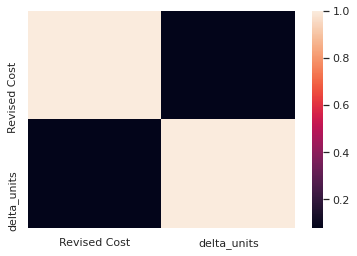

In [9]:
corrmat = features.corr()
sns.heatmap(corrmat)

In [837]:
col_imputer = ColumnTransformer(
    [
        ('empty', SimpleImputer(strategy='constant', fill_value=''), 
         [0,1]),
        ('mean', SimpleImputer(strategy='mean'),
         slice(2,cols+1))
    
    ], remainder='passthrough'
)

tfidf_params = {'max_features':500,
                'ngram_range':(1,2),
#                 'min_df':31,
                'stop_words':STOP_WORDS.union({'ll', 've', 'NaN', 'nan', 'replace','renovation','remodel'})
               }

#note for self: single column doesn't need to be in a list
# tfidf scaling for descriptions
# scaling for units added
col_trans = ColumnTransformer(
    [('tfidf', TfidfVectorizer(**tfidf_params),0), 
     ('onehot', OneHotEncoder(),[1]),
     ('scale', StandardScaler(),slice(2,cols+1))
    ],
    remainder='passthrough', sparse_threshold=0.3
)



In [838]:
reg_pipe = Pipeline([
    ('impute', col_imputer),
    ('ct', col_trans),
    ('linreg', Ridge(alpha=0.15))
])

In [839]:
_ = reg_pipe.fit(Xtrain,ytrain)

In [840]:
reg_pipe.score(Xtrain,ytrain)

0.38246387074025523

In [841]:
reg_pipe.score(Xtest, ytest)

0.3746893924577245

In [842]:
# calculate rmse 
def rmse(model, X, y):
    return np.sqrt(mean_squared_error(model.predict(X), y))

In [843]:
rmse(reg_pipe, Xtrain, ytrain)

153.64535519263657

In [844]:
rmse(reg_pipe, Xtest, ytest)

150.3089700746045

In [845]:
# here, we should write a loop to systematically test types of models including linear reg, ridge, GLM/poisson/Gaussian
# print out their rmse and R^2 scores to compare their performances
models_ = [
#            LinearRegression(), 
#             Ridge(alpha=1.3), 
#            TweedieRegressor(power=1, max_iter=500, alpha=0.025),
               RandomForestRegressor(),
#             GradientBoostingRegressor(learning_rate=0.08,
#                                       n_estimators=300, max_depth=3,
#                                       max_features='auto',
#                                       subsample=0.3
#                                      ) # not bad, but lotsmore tuning required
    

        ] # add more models here to get a baseline of performance


pipe_reg = Pipeline([
    ('impute', col_imputer),
    ('ct', col_trans),
#     ('rf', RandomForestRegressor(n_estimators=100,max_depth=5))
    ('tweed', TweedieRegressor()) #power=1.1, max_iter=500, alpha=0.025 ~r^2 .44 with little overfit
#     ('gboost', GradientBoostingRegressor(learning_rate=0.04,
#                                       n_estimators=600, max_depth=3,
#                                       max_features='auto',
#                                       subsample=0.3))
])
params = {'tweed__power': [1.18], 'tweed__alpha':[0.05],'tweed__max_iter':[1000] }
p = GridSearchCV(pipe_reg, params, n_jobs=4, verbose=4, return_train_score=True)
p.fit(Xtrain,ytrain)
print(f'Gradient Boost Reg\n\nTrain R^2: {p.score(Xtrain,ytrain)} rmse: {rmse(p,Xtrain,ytrain)}\nTest R^2:{p.score(Xtest,ytest)} rmse:{rmse(p,Xtest,ytest)}\n\n')


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    3.3s remaining:    5.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.7s finished


Gradient Boost Reg

Train R^2: 0.41162873148938495 rmse: 173.89023206119285
Test R^2:0.4071227136019617 rmse:160.7744758721871




In [846]:
p.cv_results_


{'mean_fit_time': array([2.05592093]),
 'std_fit_time': array([0.17446551]),
 'mean_score_time': array([0.12673187]),
 'std_score_time': array([0.00199483]),
 'param_tweed__alpha': masked_array(data=[0.05],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_tweed__max_iter': masked_array(data=[1000],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_tweed__power': masked_array(data=[1.18],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'tweed__alpha': 0.05,
   'tweed__max_iter': 1000,
   'tweed__power': 1.18}],
 'split0_test_score': array([0.38774789]),
 'split1_test_score': array([0.37741511]),
 'split2_test_score': array([0.37928968]),
 'split3_test_score': array([0.39323909]),
 'split4_test_score': array([0.32190197]),
 'mean_test_score': array([0.37191875]),
 'std_test_score': array([0.02565673]),
 'rank_test_score': array([1], dtype=int32),
 'split0_train_score'

In [848]:

Xshort = features[rdf['approve_days']<=180][simple_cols]
yshort = rdf[rdf['approve_days']<=180]['approve_days']

In [849]:
rmse(p,Xshort,yshort)

79.37578430580405

(array([2.3108e+04, 3.1000e+01, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   9.7403137 ,  475.85033743,  941.96036116, 1408.07038488,
        1874.18040861, 2340.29043234, 2806.40045607, 3272.51047979,
        3738.62050352, 4204.73052725, 4670.84055098]),
 <BarContainer object of 10 artists>)

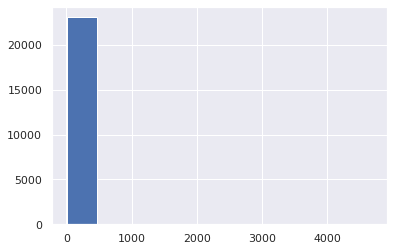

In [850]:
plt.hist(p.predict(Xshort))

In [793]:
p.best_params_

{'tweed__alpha': 0.05, 'tweed__max_iter': 1000, 'tweed__power': 1.18}

In [794]:
resids = p.predict(Xtest) - ytest

(array([5.66e+03, 9.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([-1272.62150407,   552.51401031,  2377.64952468,  4202.78503906,
         6027.92055344,  7853.05606782,  9678.1915822 , 11503.32709657,
        13328.46261095, 15153.59812533, 16978.73363971]),
 <BarContainer object of 10 artists>)

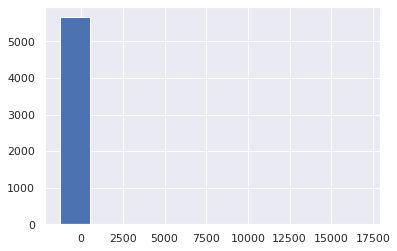

In [795]:
plt.hist(resids) #opportunity to do some residual estimation?

(array([4200.,  830.,  300.,  197.,   67.,   29.,    9.,   10.,    8.,
           5.]),
 array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
 <BarContainer object of 10 artists>)

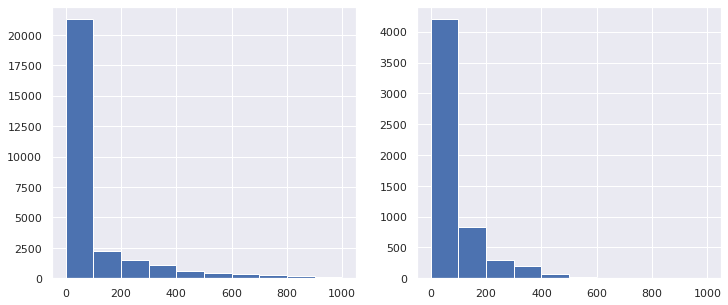

In [851]:
#poisson has a more similar distribution, even if the error is larger.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1) #training data distribution
plt.hist(labels,bins=[x*100 for x in range(11)])
plt.subplot(1,2,2)
plt.hist(p.predict(Xtest),bins=[x*100 for x in range(11)]) # test prediction distribution


In [887]:
import random
n=random.randint(0,features.shape[0])

print(n, [features.iloc[n].values])

16989 [array(['revision to pa -- - remove  deck post and deepen joist; footing details @ exterior stair; interior stair post update',
       'Noe Valley', 2000.0, 0.0], dtype=object)]


In [888]:
p.predict([features.iloc[n]])

array([24.50134581])

In [889]:
labels.iloc[n]

36

In [73]:
features['Description']

6         comply with nov  permit for furnace/water heat...
10        unit legalization ord #-. interior alteration ...
13        legalization of dwelling unit installed withou...
17        addition of new unit on st floor. no exterior ...
21        horizontal & vertical addition, interior remod...
                                ...                        
129451    renovation of kitchen, bathroom & bedroom @ al...
129452    adu: (n) dwelling unit being added at ground l...
129453    adu: (n) dwelling unit being added at ground l...
129454    rear addition to (e) dwelling units. total  ne...
129455    addition of dwelling unit per ordinance #-. gr...
Name: Description, Length: 28353, dtype: object

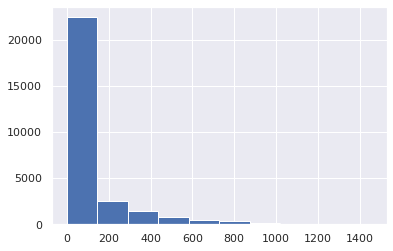

In [20]:
rdf[legal_cols].approve_days.hist()

In [42]:
targets.iloc[10]

305

# Dump the model to Dill for Export

In [821]:
p

GridSearchCV(estimator=Pipeline(steps=[('impute',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('empty',
                                                                         SimpleImputer(fill_value='',
                                                                                       strategy='constant'),
                                                                         [0,
                                                                          1]),
                                                                        ('mean',
                                                                         SimpleImputer(),
                                                                         slice(2, 16, None))])),
                                       ('ct',
                                        ColumnTransformer(remainder='passthrough',
                     

In [852]:
dill.dump(p.best_estimator_, open('./Pickled/not_OTC_regressor.dill', 'wb'))

In [853]:
preg = dill.load(open('./Pickled/not_OTC_regressor.dill', 'rb'))

In [854]:
preg.score(Xtest,ytest)

0.4071227136019617

In [861]:
preg.predict(Xtest[:1].values)

array([27.73543868])

In [866]:
arr = Xtest[:1].values
arr = [i for i in arr]

In [870]:
a = [['voluntary seismic upgrade at gr level consisting of grade beams, shear wall, and hardy panels, moment frame', 'Western Addition', 20000.0, 0.0]]

In [877]:
p.predict(a)[0]

27.735438684845754

In [876]:
ytest[:1]

94347    0
Name: approve_days, dtype: int64

# Create Visualization for model performance @ different date ranges

In [13]:
# load up the model 
preg = dill.load(open('./Pickled/not_OTC_regressor.dill', 'rb'))

In [14]:
preg.predict(Xtest[:10].values)

array([107.93972483, 540.74900647, 133.50315188,  74.46139485,
        29.53563872,  67.71740829,  17.58075009,  42.59193889,
       204.59914988,  36.53736664])

In [20]:
rmse_predict(preg, Xtest[:10], ytest[:10])

142.87848153777637

In [23]:
ytest.shape[0] == Xtest.shape[0]

True

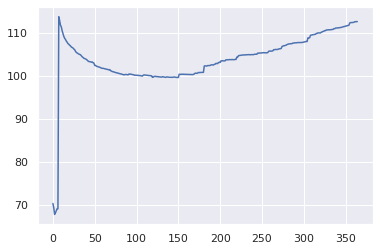

In [36]:
# repeatedly filter by indices to get different approval ranges
error_list = []
days_list = [i for i in range(365)]
for ndays in days_list: # cutoff for accuracy
    filter_indices = ytest<=ndays
    error = rmse_predict(preg, Xtest[filter_indices], ytest[filter_indices])
    error_list.append( error)
    
    
plt.plot(days_list, error_list)